In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load cleaned data
df = pd.read_csv("../data/processed/cleaned_fake_news.csv")

X = df['content'].fillna("")
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (35918,)
Test size: (8980,)


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 20000   # top words to keep
max_len = 300       # max length of each article

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

print("Train shape:", X_train_pad.shape)

Train shape: (35918, 300)


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

embedding_dim = 100

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.build(input_shape=(None, max_len))
model.summary()

C:\Users\kausalya\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 300, 100)            │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,125,569 (8.11 MB)

 Trainable params: 2,125,569 (8.11 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    batch_size=128,
    verbose=1
)

Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.7169 - loss: 0.5634 - val_accuracy: 0.5998 - val_loss: 0.6527
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 135s 481ms/step - accuracy: 0.6669 - loss: 0.5630 - val_accuracy: 0.9173 - val_loss: 0.2783
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 135s 481ms/step - accuracy: 0.7628 - loss: 0.4878 - val_accuracy: 0.7885 - val_loss: 0.4787
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 135s 482ms/step - accuracy: 0.8071 - loss: 0.4411 - val_accuracy: 0.8226 - val_loss: 0.4020
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 138s 493ms/step - accuracy: 0.8936 - loss: 0.2992 - val_accuracy: 0.4886 - val_loss: 0.7801
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 146s 520ms/step - accuracy: 0.8481 - loss: 0.3823 - val_accuracy: 0.9141 - val_loss: 0.2481
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 149s 532ms/step - accuracy: 0.9094 - loss: 0.2849 - val_accuracy: 0.5831 - val_loss: 0.5960
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 161s 575ms/step - accuracy: 0.6318 - lo

In [5]:
loss, acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.9582


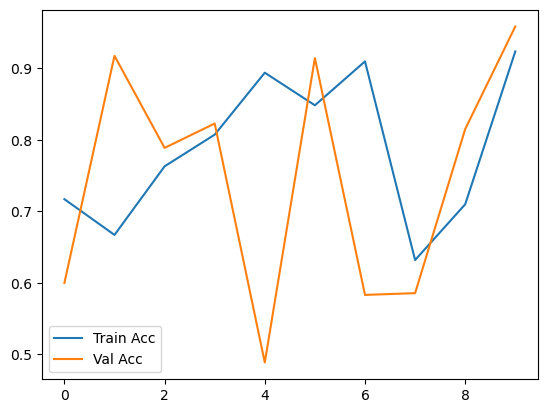

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.show()

In [7]:
model.save("../models/lstm_model.h5")

import joblib
joblib.dump(tokenizer, "../models/tokenizer.pkl")

['../models/tokenizer.pkl']

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions (probabilities → convert to 0/1)
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

281/281 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.96      4284
           1       0.94      0.98      0.96      4696

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980

Confusion Matrix:
 [[3984  300]
 [  75 4621]]


In [9]:
import numpy as np

np.save("../data/processed/X_train_pad.npy", X_train_pad)
np.save("../data/processed/X_test_pad.npy", X_test_pad)
np.save("../data/processed/y_train.npy", y_train)
np.save("../data/processed/y_test.npy", y_test)

In [10]:
import numpy as np

embedding_index = {}
with open("../glove/glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coef = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coef

print("Loaded %s word vectors." % len(embedding_index))


Loaded 400000 word vectors.


In [11]:
embedding_dim = 100
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

model = Sequential([
    Embedding(num_words, embedding_dim,
              weights=[embedding_matrix],
              input_length=X_train_pad.shape[1],
              trainable=False),   # freeze embeddings
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model.build(input_shape=(None, X_train_pad.shape[1]))
model.summary()


C:\Users\kausalya\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 300, 100)            │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 300, 256)            │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 300, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,407,169 (9.18 MB)

 Trainable params: 407,169 (1.55 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [13]:
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=5,
    batch_size=128,
    verbose=1
)

Epoch 1/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 930s 3s/step - accuracy: 0.9633 - loss: 0.1001 - val_accuracy: 0.9816 - val_loss: 0.0470
Epoch 2/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 1035s 4s/step - accuracy: 0.9861 - loss: 0.0391 - val_accuracy: 0.9866 - val_loss: 0.0380
Epoch 3/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 906s 3s/step - accuracy: 0.9906 - loss: 0.0266 - val_accuracy: 0.9874 - val_loss: 0.0320
Epoch 4/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 886s 3s/step - accuracy: 0.9912 - loss: 0.0244 - val_accuracy: 0.9915 - val_loss: 0.0276
Epoch 5/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 731s 3s/step - accuracy: 0.9909 - loss: 0.0253 - val_accuracy: 0.9886 - val_loss: 0.0297


In [19]:
# Save
model.save("../models/bilstm_model.h5")

# Load later
from tensorflow.keras.models import load_model
loaded_model = load_model("../models/bilstm_model.h5")